In [1]:
# For those who stored the exported high-res label(s) to the Google Drive, plase mount at the googld derive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please export the high-res label(s) from GroundWork using "export data" tab. You only need to select the check-box of tile layer for the image options.
Then you can DL catalog.zip from GroundWork. In this notebook, you will import the geojason file (catalog/labels/data/xxx.geojson) in which the high-res label data are stored.
We also import the original NLCD low-res label, but this is only to get the size of the *label*.

Note that we need to at least label the upper left and the lower right corner (or the upper right and the lower left) of the original NAIP image (no need to do for each devided part by GroundWork, typically 36), because the largest and smallest coordinates are required to accurately transform to a png image file.

The outputs of this notebook are two images which will be saved to the working folder (if using the Google Colab, they would be saved under /contents)

- image: rgb image with three channels (light blue:Water, dark green:Tree Canopy, light green:Low Vegetation, red:Impervious). Use this to visually check the curated high-res label.

- image2: gray-scale image with only one channel (0:Water, 1:Tree Canopy, 2:Low Vegetation, 3:Impervious. Note that these are the same with Codalab https://codalab.lisn.upsaclay.fr/competitions/7908). Use this to test our models.

In [2]:
import sys
from osgeo import gdal,ogr,osr
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import json
import pandas as pd
import numpy as np
import re

In [3]:
# URL of the corresponding NLCD image. Please change to your file name (path)
!wget -P /content https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/3137_nlcd-2013.tif

--2022-10-26 23:15:56--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/3137_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606037 (592K) [application/octet-stream]
Saving to: ‘/content/3137_nlcd-2013.tif’

3137_nlcd-2013.tif  100%[===================>] 591.83K  1.26MB/s    in 0.5s    

2022-10-26 23:15:56 (1.26 MB/s) - ‘/content/3137_nlcd-2013.tif’ saved [606037/606037]



In [4]:
# File path of the downloaded NLCD image. Please change to your file name (path)
nlcd_fn = '/content/3137_nlcd-2013.tif'

ds = gdal.Open(nlcd_fn, gdal.GA_ReadOnly)
a = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
target_Width = ds.RasterXSize
target_Height = ds.RasterYSize
print(a)
print(a.shape)
print(target_Width, target_Height)

[[[82 82 82 ... 23 23 23]
  [82 82 82 ... 23 23 23]
  [82 82 82 ... 23 23 23]
  ...
  [21 21 21 ... 82 82 82]
  [21 21 21 ... 82 82 82]
  [21 21 21 ... 82 82 82]]]
(1, 3880, 3880)
3880 3880


In [5]:
txt = gdal.Info(nlcd_fn)
extracted_UL = re.search('Upper Left\s+\(\S*, \S*\) \( \S*\s\S*N', txt).group()
extracted_UL_x = re.search('Upper Left\s+\(\S*, \S*\) \( \S*W', extracted_UL).group()
extracted_UL_y = re.search('W,\s\S*N', extracted_UL).group()

Xmin_ms = re.search('.\d*"',extracted_UL_x).group()[1:-1]
Xmin_sec = re.search('\'\d*.',extracted_UL_x).group()[1:-1]
Xmin_min = re.search('d\d*\'',extracted_UL_x).group()[1:-1]
Xmin_deg = re.search('\s\d*d',extracted_UL_x).group()[1:-1]
_mapXmin_ = -(int(Xmin_deg) + int(Xmin_min)/60 + int(Xmin_sec)/3600 + int(Xmin_ms)/3600000)

Ymax_ms = re.search('.\d*"',extracted_UL_y).group()[1:-1]
Ymax_sec = re.search('\'\d*.',extracted_UL_y).group()[1:-1]
Ymax_min = re.search('d\d*\'',extracted_UL_y).group()[1:-1]
Ymax_deg = re.search('\s\d*d',extracted_UL_y).group()[1:-1]
_mapYmax_ = int(Ymax_deg) + int(Ymax_min)/60 + int(Ymax_sec)/3600 + int(Ymax_ms)/3600000


extracted_LR = re.search('Lower Right\s+\(\S*, \S*\) \( \S*\s\S*N', txt).group()
extracted_LR_x = re.search('Lower Right\s+\(\S*, \S*\) \( \S*W', extracted_LR).group()
extracted_LR_y = re.search('W,\s\S*N', extracted_LR).group()

Xmax_ms = re.search('.\d*"',extracted_LR_x).group()[1:-1]
Xmax_sec = re.search('\'\d*.',extracted_LR_x).group()[1:-1]
Xmax_min = re.search('d\d*\'',extracted_LR_x).group()[1:-1]
Xmax_deg = re.search('\s\d*d',extracted_LR_x).group()[1:-1]
_mapXmax_ = -(int(Xmax_deg) + int(Xmax_min)/60 + int(Xmax_sec)/3600 + int(Xmax_ms)/3600000)

Ymin_ms = re.search('.\d*"',extracted_LR_y).group()[1:-1]
Ymin_sec = re.search('\'\d*.',extracted_LR_y).group()[1:-1]
Ymin_min = re.search('d\d*\'',extracted_LR_y).group()[1:-1]
Ymin_deg = re.search('\s\d*d',extracted_LR_y).group()[1:-1]
_mapYmin_ = int(Ymin_deg) + int(Ymin_min)/60 + int(Ymin_sec)/3600 + int(Ymin_ms)/3600000

X and Y-coordinates are longitude and latitude respectively
mapXmin: -77.8879528
mapXmax: -77.8430371
mapYmin: 39.54689599999999
mapYmax: 39.58152199999998

from corresponding NLCD
mapXmin: -76.89973055555555
mapXmax: -76.85473888888889
mapYmin: 39.58140222222223
mapYmax: 39.61611305555555
Note that it seems to be better to use the one from the exported high-res label from GroundWork

W: 0.04491569999999001
H: 0.03462599999998872
pixel_size_x: 1.1576211340203612e-05
pixel_size_y: 8.924226804120804e-06

size of image: (3880, 3880)
size of image2: (3880, 3880)
size of image -- rbg: (3880, 3880, 3) as numpy array
size of image2 -- gray-scale: (3880, 3880) as numpy array

---Distribution-------------------
0:Water
1:Tree Canopy
2:Low Vegetation
3:Impervious

1    8836205
2    4219215
3    1156885
0     842095
dtype: int64


image(rgb)


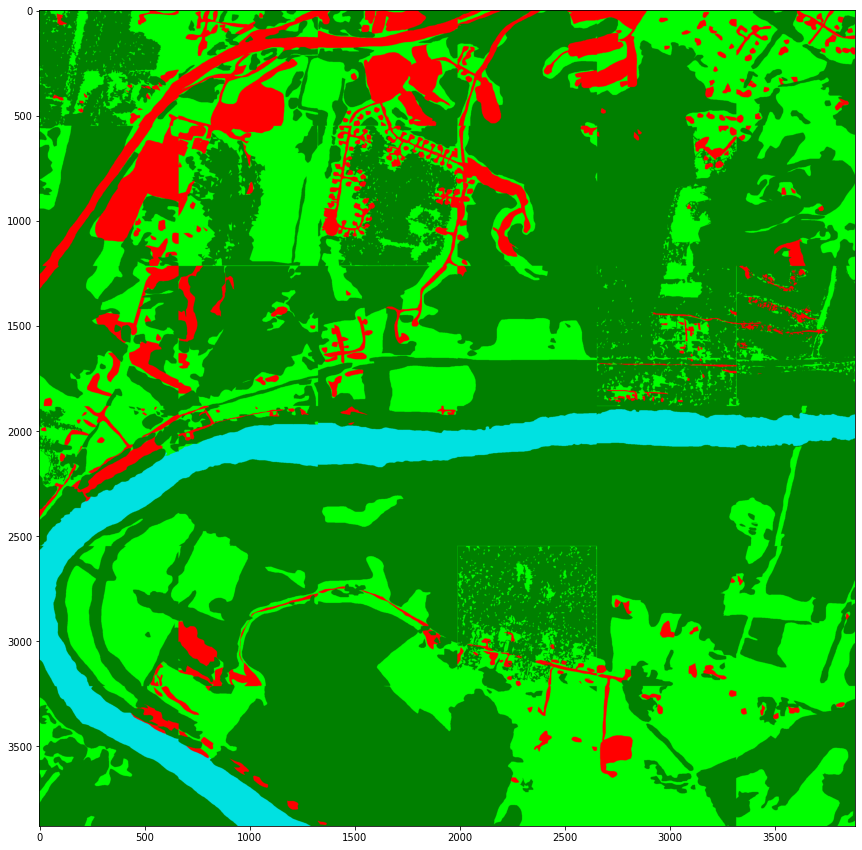


image2(gray-scale)


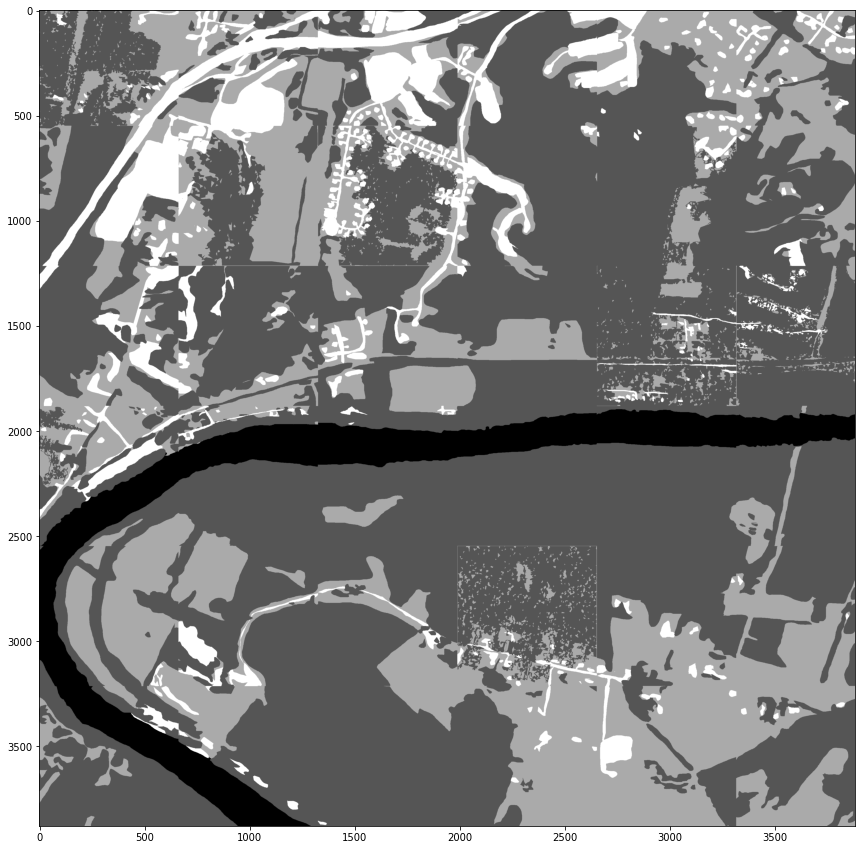


NLCD low-res label(gray-scale)


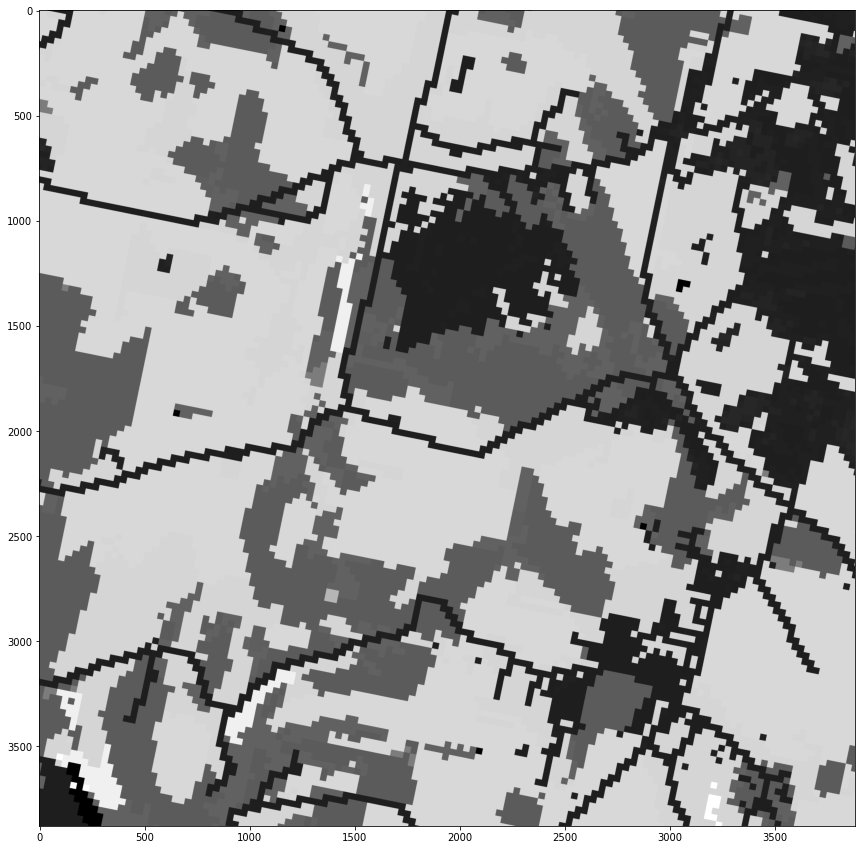

In [6]:
# Filename of the exported label data (/catalog/labels/data/xxx.geojson) from GroundWork. Please change to your file name (path)
vector_fn = '/content/drive/MyDrive/image1.geojson'
# vector_fn = '/content/240f5d5e-63f9-4cf8-bc56-b05e5f2fd28f.geojson'

# Open the data source and read in the extent
datasource = ogr.Open(vector_fn)

if datasource is None:
  print ('Could not open file')
  sys.exit(1)

vector_layer = datasource.GetLayer()

mapXmin, mapXmax, mapYmin, mapYmax = vector_layer.GetExtent()
# http://gdal.org/python/osgeo.ogr.Layer-class.html#GetExtent

print('X and Y-coordinates are longitude and latitude respectively')
print ("mapXmin:",mapXmin)
print ("mapXmax:",mapXmax)
print ("mapYmin:",mapYmin)
print ("mapYmax:",mapYmax)
print()
print('from corresponding NLCD')
print ("mapXmin:",_mapXmin_)
print ("mapXmax:",_mapXmax_)
print ("mapYmin:",_mapYmin_)
print ("mapYmax:",_mapYmax_)
print('Note that it seems to be better to use the one from the exported high-res label from GroundWork')

print()

print ("W:",mapXmax-mapXmin)
print ("H:",mapYmax-mapYmin)

# Define pixel_size 
# pixel_size = 0.5 # meters are one pixel
# Create the target data source
pixel_size_x = abs(mapXmax - mapXmin) / target_Width
pixel_size_y = abs(mapYmax - mapYmin) / target_Height

print ("pixel_size_x:",pixel_size_x)
print ("pixel_size_y:",pixel_size_y)

source = open(vector_fn)
src = json.load(source)

image_TC = Image.new('RGB', (target_Width, target_Height))
image2_TC = Image.new('L', (target_Width, target_Height))
image_Im = Image.new('RGB', (target_Width, target_Height))
image2_Im = Image.new('L', (target_Width, target_Height))
image_W = Image.new('RGB', (target_Width, target_Height))
image2_W = Image.new('L', (target_Width, target_Height))
image_LV = Image.new('RGB', (target_Width, target_Height))
image2_LV = Image.new('L', (target_Width, target_Height))

draw_TC = ImageDraw.Draw(image_TC)
draw2_TC = ImageDraw.Draw(image2_TC)
draw_Im = ImageDraw.Draw(image_Im)
draw2_Im = ImageDraw.Draw(image2_Im)
draw_W = ImageDraw.Draw(image_W)
draw2_W = ImageDraw.Draw(image2_W)
draw_LV = ImageDraw.Draw(image_LV)
draw2_LV = ImageDraw.Draw(image2_LV)


# Loop through the features in the layer
for ftr in src.get('features'):

  prop = ftr.get('properties') 
  att = prop['default']

  coors = ftr['geometry']['coordinates']  #4Dcoordata

  for multipolygon in coors:
    for polygon in multipolygon:

      polygon = np.array(polygon)

      loc = np.argmax(polygon[:,0])

      v1 = polygon[loc]-polygon[loc-1]
      v2 = polygon[loc+1]-polygon[loc-1]

      outprod = v1[0]*v2[1]-v1[1]*v2[0]

      polygon -= np.array([mapXmin, mapYmax])
      polygon *= np.array([1,-1])
      polygon /= np.array([pixel_size_x, pixel_size_y])
      polygon = polygon.tolist()
      polygon = [(a[0],a[1]) for a in polygon]

      if outprod >= 0:
        if(att == 'Tree Canopy'):
          color = (0,128,0); color2 = 1 #dark green
          draw_TC.polygon(polygon, fill = color, outline =None)
          draw2_TC.polygon(polygon, fill = color2, outline =None)
        elif(att == 'Impervious'):
          color = (255,0,0); color2 = 3 #red
          draw_Im.polygon(polygon, fill = color, outline =None)
          draw2_Im.polygon(polygon, fill = color2, outline =None)
        elif(att == 'Water'):
          color = (0,225,225); color2 = 0 #light blue
          draw_W.polygon(polygon, fill = color, outline =None)
          draw2_W.polygon(polygon, fill = color2, outline =None)
        elif(att == 'Low Vegetation'):
          color = (0,255,0); color2 = 2 #light green
          draw_LV.polygon(polygon, fill = color, outline =None)
          draw2_LV.polygon(polygon, fill = color2, outline =None)
        else: raise ValueError('Wrong target class!')
      else:
        if(att == 'Tree Canopy'):
          draw_TC.polygon(polygon, fill = (0,0,0), outline =None)
          draw2_TC.polygon(polygon, fill = 0, outline =None)
        elif(att == 'Impervious'):
          draw_Im.polygon(polygon, fill = (0,0,0), outline =None)
          draw2_Im.polygon(polygon, fill = 0, outline =None)
        elif(att == 'Water'):
          draw_W.polygon(polygon, fill = (0,0,0), outline =None)
          draw2_W.polygon(polygon, fill = 0, outline =None)
        elif(att == 'Low Vegetation'):
          draw_LV.polygon(polygon, fill = (0,0,0), outline =None)
          draw2_LV.polygon(polygon, fill = 0, outline =None)
        else: raise ValueError('Wrong target class!')

image_TC_np = np.array(image_TC)
image2_TC_np = np.array(image2_TC)
image_Im_np = np.array(image_Im)
image2_Im_np = np.array(image2_Im)
image_W_np = np.array(image_W)
image2_W_np = np.array(image2_W)
image_LV_np = np.array(image_LV)
image2_LV_np = np.array(image2_LV)

#prioritize in order of Im ->  LV ->  TC ->  W

image_LV_np[np.sum(image_Im_np, axis=-1) > 0,:] = 0
image_TC_np[np.sum(image_Im_np, axis=-1) > 0,:] = 0
image_W_np[np.sum(image_Im_np, axis=-1) > 0,:] = 0
image2_LV_np[image2_Im_np > 0] = 0
image2_TC_np[image2_Im_np > 0] = 0
image2_W_np[image2_Im_np > 0] = 0

image_TC_np[np.sum(image_LV_np, axis=-1) > 0,:] = 0
image_W_np[np.sum(image_LV_np, axis=-1) > 0,:] = 0
image2_TC_np[image2_LV_np > 0] = 0
image2_W_np[image2_LV_np > 0] = 0

image_W_np[np.sum(image_TC_np, axis=-1) > 0,:] = 0
image2_W_np[image2_TC_np > 0] = 0

image_np = image_TC_np + image_Im_np + image_W_np + image_LV_np
image2_np = image2_TC_np + image2_Im_np + image2_W_np + image2_LV_np

image = Image.fromarray(image_np)
image2 = Image.fromarray(image2_np)

print()
print(f'size of image: {image.size}')
print(f'size of image2: {image2.size}')

print(f'size of image -- rbg: {image_np.shape} as numpy array')
print(f'size of image2 -- gray-scale: {image2_np.shape} as numpy array')

print()
print('---Distribution-------------------')
print('0:Water')
print('1:Tree Canopy')
print('2:Low Vegetation')
print('3:Impervious')
print()
print(pd.Series(image2_np.flatten()).value_counts())

image.save('image.png')
image.save('image2.png')

print()
print()
print('image(rgb)')
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

print()
print('image2(gray-scale)')
plt.figure(figsize=(15,15))
plt.imshow(image2, cmap = 'gray')
plt.show()

print()
print('NLCD low-res label(gray-scale)')
plt.figure(figsize=(15,15))
plt.imshow(a[0], cmap = 'gray')
plt.show()

### Distribution - Percentage of each categories - Pie chart

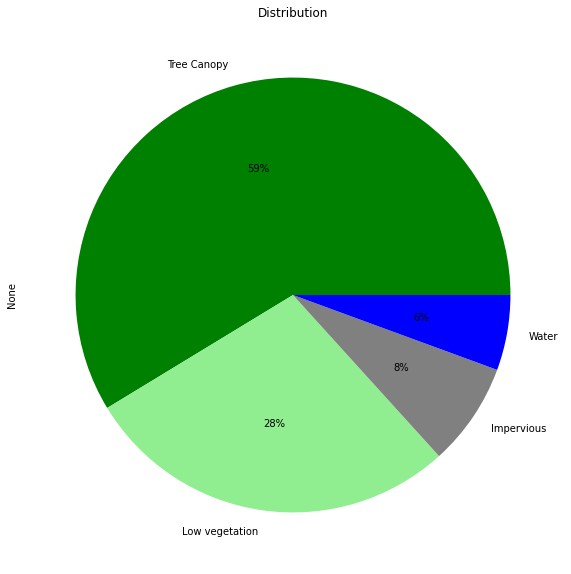

In [7]:
labels = ['Tree Canopy', 'Low vegetation', 'Impervious', 'Water']
colors = ['green', 'lightgreen', 'gray', 'blue']
plt.figure(figsize=(20,10))
pd.Series(image2_np.flatten()).value_counts().plot(kind='pie', labels = labels, colors = colors, autopct='%.0f%%', title='Distribution')

The distribution of different areas in a specific zone of Maryland is plotted. Like most zones, this specific zone also contains majorly Tree Canopy. Also, this zone contains a relatively higher percentage of water compared to the other zone as in most zones, percentage of water is mostly negligible. 
